# 开始

> tensorflow的学习成本有点高。而且。现在好像更多的人pytorch在做训练。改成pytorch吧。改天回来复习这一块，试一试能不能用上。
> 我发现我这种菜鸡，无论是什么框架都搞不出来。这几天，先把这个搞定。然后按着计划复习。

## 实现过程

1. 通过tff.simulation.datasets加载tff.simulation.ClientData类型的数据集。
2. 并使用tf.data.dataset处理数据集。
3.1. 通过tf.keras.models和tff.learning.Model构造联邦学习模型。
3.2. 通过tff.learning.build_federated_averaging_process实现联邦聚合算法。通过tf.keras实现前向传播算法。
3.3. 通过tf.kerase.loss实现损失计算方法
3.4. 通过tf.kerase.optimizers.SGD实现优化算法

In [1]:
# 配置异步IO
import nest_asyncio
nest_asyncio.apply()

import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


b'Hello, World!'

## 1 加载数据

× 通过tff.simulation.datasets加载实验数据。返回多个tff.simulation.ClientData实例。

In [2]:
# 1 加载数据
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

97402880/97398400 [==============================] - 10s 0us/step


In [8]:
# 1 查看数据内容

print(len(emnist_train.client_ids))
print(emnist_train.element_type_structure)

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

print(example_element.keys())
print(example_element['label'].numpy())
print(example_element['pixels'])

3383
OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)), ('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])
odict_keys(['label', 'pixels'])
5
tf.Tensor(
[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.     

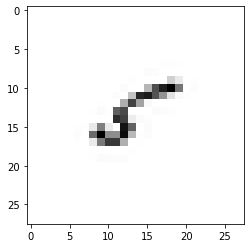

In [4]:
# 1 查看数据几中的数据。
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

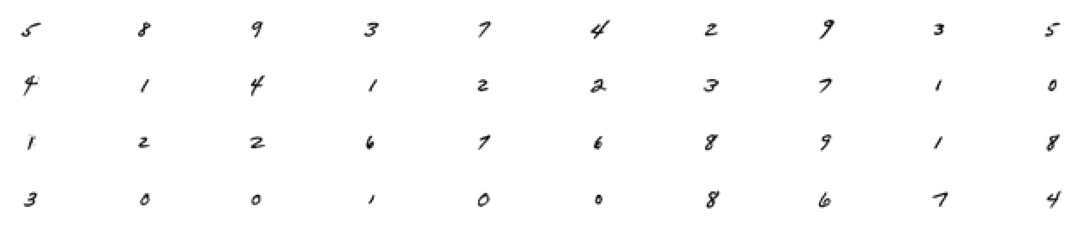

In [9]:
# 1 探索数据集中的异构性。
# 从某一个用户的数据集中取出40条数据，验证数据内容。
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

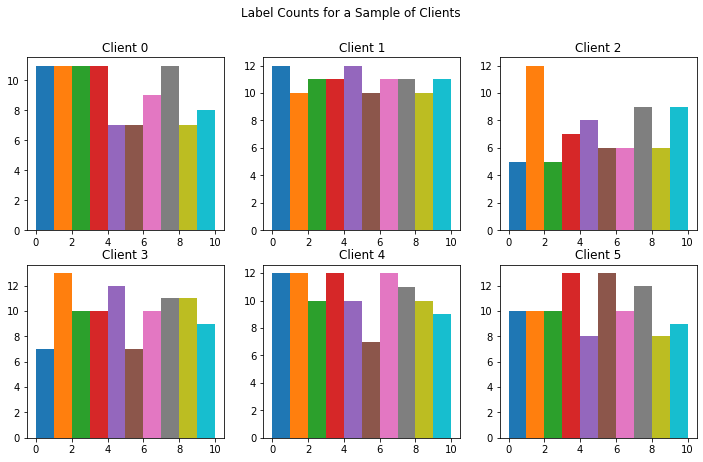

In [10]:
# 1 探索数据集中的异构行
# 每个客户端上数字标签的示例数量，可能不同。取决于用户的行为（不平衡的）
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

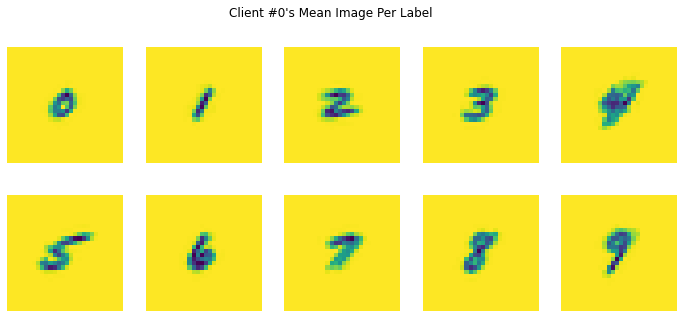

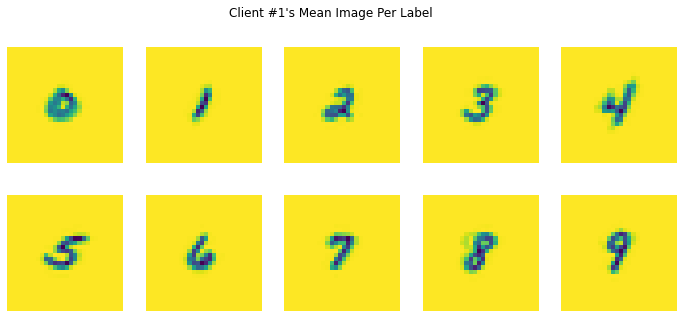

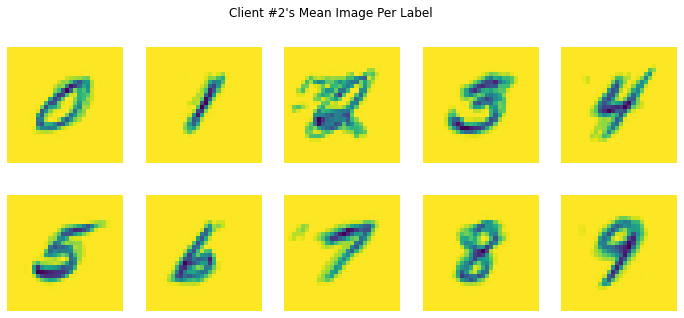

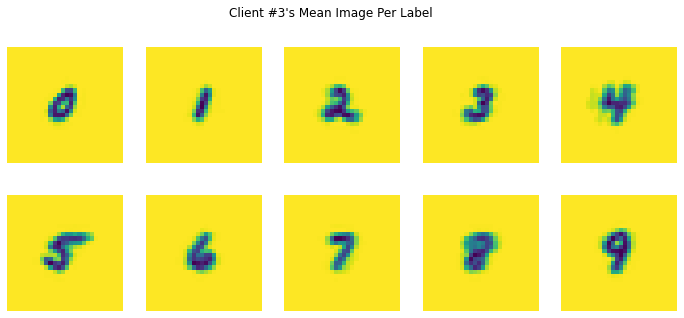

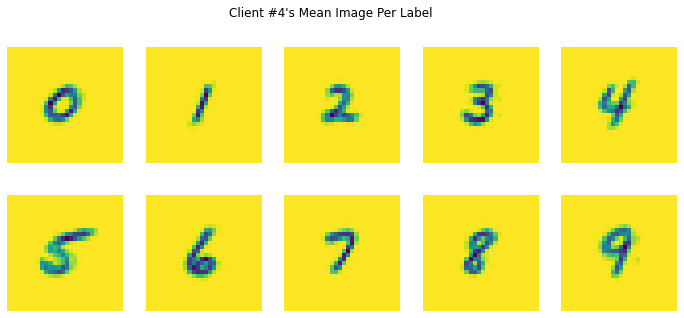

In [11]:
# 1 查看数据的异构行。
# 用来显示每个用户的平局图像
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

# 2 数据处理

主要使用tf.dataset方法，将原始数据转换为list，方便输入和训练。

In [12]:
# 2 对数据进行预处理
# 将数据分成多个不同的批次(某一个客户端的数据)

NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [13]:
# 2 检验数据处理的结果
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y',
              array([[7],
                     [2],
                     [8],
                     [6],
                     [6],
                     [3],
                     [1],
                     [7],
                     [1],
                     [8],
                     [3],
                     [7],
                     [4],
                     [3],
                     [6],
                     [3],
                     [0],
                     [3],
                     [1],
                     [5]], dtype=int32))])

In [14]:
# 2 通过simulation dataset构建训练数据的列表.
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [15]:
# 2 实现客户端的选择
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


# 3 模型训练
1. 构建了keras模型，转换为tff模型。
2. 进行正向传播，实现联邦聚合算法。
3. 定义损失函数。
4. 定义优化方法。
5. 进行反向传播。

In [16]:
# 3.1 使用keras创建模型
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

In [17]:
# 3.1 通过keras模型转换为tff模型
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [20]:
# 3.2-3.3-3.4定义前像传播过程、定义损失计算方法、定义优化方法
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [21]:
# 3 查看联邦计算过程
print(str(iterative_process.initialize.type_signature))

( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)


In [22]:
# 3 服务器初始化状态

state = iterative_process.initialize()

In [23]:
# 3 客户端进行单轮训练
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.119135804), ('loss', 3.0766096)])), ('stat', OrderedDict([('num_examples', 4860)]))])


In [25]:
# 3 客户端进行多伦训练
NUM_ROUNDS = 30
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.35864198), ('loss', 1.9986831)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.38539094), ('loss', 1.8443733)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.43024692), ('loss', 1.7397194)])), ('stat', OrderedDict([('num_examples', 4860)]))])
round  5, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.3962963), ('loss', 1.8008

In [26]:
# 4 使用tensorboard进行可视化，并对过程进行评估
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

In [27]:
# 4 绘制相关的标量，包括accurate和loss
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    for name, value in metrics['train'].items():
      tf.summary.scalar(name, value, step=round_num)

!ls {logdir}

%tensorboard --logdir {logdir} --port=0

![tensorboard过程](2021-05-06 20-44-37屏幕截图.png)